### 합성 데이터를 활용한 유방암 주요 예측 변수 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [16]:
train = pd.read_csv('Adjusted_synbreast_trainset.csv')

train.columns = train.columns.astype(str)

In [17]:
train.head()

,No,AGE,inductal carcinoma,infiltrating duct carcinoma,adenocarcinoma,lobular carcinoma,Metaplastic carcinoma,T1,T1mi,T1a,...,PR,AR,BCS,Mestectomy,pan hysterosalpingo oophorectomy,Chemotherapy,Hormone therapy,Radiation Therapy,Death,Survival period
0,0,33,0,1,0,0,1,1,0,0,...,2,9,1,99,0,1,0,1,0,472
1,1,72,0,1,1,1,0,0,0,1,...,1,99,1,0,0,0,1,1,0,835
2,2,41,0,0,0,0,0,0,0,1,...,99,9,99,1,0,1,1,0,1,1136
3,3,61,1,0,0,1,0,1,0,0,...,1,99,99,0,0,0,1,1,1,145
4,4,44,0,1,0,0,0,0,1,0,...,2,99,0,99,0,0,1,1,1,906


##### 원본 타겟 변수

- 4-50대 사망여부 보기

In [18]:
age_filter = train[(train['AGE'] >= 40) & (train['AGE'] <= 59)]
death_count = age_filter['Death'].value_counts()

print('<4-50대 환자들의 사망여부 카운트>')
print(death_count)

<4-50대 환자들의 사망여부 카운트>
Death
0    2599
1    1344
Name: count, dtype: int64


In [19]:
print(train['Death'].value_counts())

Death
0    6524
1    3476
Name: count, dtype: int64


In [20]:
def col(df):
    #모든 컬럼
    all_col = df.columns.tolist()
    #수치형 컬럼만
    num_col = df.select_dtypes(include=['number']).columns.tolist()  #수치형 데이터만 선택
    #범주형 컬럼
    cat_col = df.select_dtypes(include=['object']).columns.tolist()  #범주형 데이터만 선택
    
    return num_col, cat_col

print(f'train([수치형], [범주형])\n {col(train)}\n')

train([수치형], [범주형])
 (['No', 'AGE', 'inductal carcinoma', 'infiltrating duct carcinoma', 'adenocarcinoma', 'lobular carcinoma', 'Metaplastic carcinoma', 'T1', 'T1mi', 'T1a', 'T1b', 'T1c', 'T2', 'T2a', 'T2b', 'T3', 'T4', 'N1mi', 'N1', 'N1a', 'N1b', 'N1c', 'N2', 'N2a', 'N2b', 'N3', 'N3a', 'N3b', 'N3c', 'M1', 'M1a', 'M1b', 'Type of Drink', 'Smoke', 'Age of Menarch', 'Age of Menopause', 'Marriage', 'Age at first birth', 'Number of births', 'COCP', 'HRT', 'Height', 'Weight', 'BRCA1 PVs', 'BRCA1 VUS', 'BRCA2 PVs', 'BRCA2 VUS', 'ER', 'PR', 'AR', 'BCS', 'Mestectomy', 'pan hysterosalpingo oophorectomy', 'Chemotherapy', 'Hormone therapy', 'Radiation Therapy', 'Death', 'Survival period'], [])



##### 데이터 전처리

In [21]:
def feature_engineering(df):
    #columns명이 띄어쓰기로 되어있으면 오류가 발생할 수 있으니, _로 대체
    df.columns = df.columns.str.replace(' ', '_')
    df.drop(['No'], axis=1, inplace=True)  #No 컬럼 삭제
    df.loc[df['AR']==9, 'AR'] == 90  #AR 값 통일
    
    #결측값을 특정 값으로 대체
    df.loc[df['Type_of_Drink'] == 99, 'Type_of_Drink'] = 3  #3은 '기타'
    #평균으로 대체
    #Age_of_Menarch, Age_of_Menopause의 데이터 타입 변경
    df['Age_of_Menarch'] = df['Age_of_Menarch'].astype(float)
    df['Age_of_Menopause'] = df['Age_of_Menopause'].astype(float)
    df.loc[df['Age_of_Menarch'] == 99, 'Age_of_Menarch'] = df['Age_of_Menarch'].mean()  
    df.loc[df['Age_of_Menopause'] == 99, 'Age_of_Menopause'] = df['Age_of_Menopause'].mean()  

    #무응답은 2로 대체
    for column in ['Marriage', 'COCP', 'HRT', 
                    'BCS', 'Mestectomy', 'pan_hysterosalpingo_oophorectomy']:
        df.loc[df[column] == 99, column] = 2  # 해당 사항 없음 -> 2로 처리

    for column in ['BRCA1_PVs', 'BRCA1_VUS', 'BRCA2_PVs', 'BRCA2_VUS']:
        df.loc[df[column] == 1, column] = 0  #detected -> 0으로
        df.loc[df[column] == 99, column] = 2  #Unknown/Not Applicable -> 2로
        
    #ER, PR, AR 
    for column in ['ER', 'PR', 'AR']:
        df.loc[df[column] == 2, column] = 0  #not detected -> 0으로
        df.loc[df[column] == 99, column] = 2  #Unknown/Not Applicable -> 2로
    
    # 99를 0으로 변환
    df.loc[df['Age_at_first_birth'] == 99, 'Age_at_first_birth'] = 0
    df.loc[df['Number_of_births'] == 99, 'Number_of_births'] = 0

    return df

In [22]:
train = feature_engineering(train)

display(train)

,AGE,inductal_carcinoma,infiltrating_duct_carcinoma,adenocarcinoma,lobular_carcinoma,Metaplastic_carcinoma,T1,T1mi,T1a,T1b,...,PR,AR,BCS,Mestectomy,pan_hysterosalpingo_oophorectomy,Chemotherapy,Hormone_therapy,Radiation_Therapy,Death,Survival_period
0,33,0,1,0,0,1,1,0,0,0,...,0,9,1,2,0,1,0,1,0,472
1,72,0,1,1,1,0,0,0,1,0,...,1,2,1,0,0,0,1,1,0,835
2,41,0,0,0,0,0,0,0,1,0,...,2,9,2,1,0,1,1,0,1,1136
3,61,1,0,0,1,0,1,0,0,0,...,1,2,2,0,0,0,1,1,1,145
4,44,0,1,0,0,0,0,1,0,0,...,0,2,0,2,0,0,1,1,1,906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,41,1,0,1,1,0,0,0,0,1,...,1,9,2,0,1,1,1,0,1,1817
9996,32,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,1,1,0,107
9997,56,1,1,0,1,1,1,0,0,0,...,0,1,1,2,0,0,1,1,0,253
9998,64,0,0,0,1,0,1,0,0,0,...,0,1,1,0,0,0,0,1,1,687


- 수치형 변수: 정규화

In [23]:
from sklearn.preprocessing import MinMaxScaler
#정규화할 컬럼 목록
columns_to_scale = ['Survival_period', 'Height', 'Weight',
                    'Age_of_Menopause', 'Age_of_Menarch', 'Age_at_first_birth', 'Number_of_births']

scaler = MinMaxScaler()
train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])

- 범주형 변수: 원-핫 인코딩

In [24]:
train = pd.get_dummies(train, columns=['Type_of_Drink', 'Smoke', 'Marriage', 'COCP', 'HRT',
                                       'BRCA1_PVs', 'BRCA1_VUS', 'BRCA2_PVs', 'BRCA2_VUS',
                                       'ER', 'PR', 'AR',
                                       'BCS', 'Mestectomy', 'pan_hysterosalpingo_oophorectomy'], drop_first=True)

In [25]:
#데이터 전처리 저장
train.to_csv('final_train.csv')

- 원본 데이터 성능 평가

In [67]:
# from sklearn.model_selection import train_test_split

# X = train.drop(columns=['Death', 'Survival_period'], errors='ignore')  
# y = train['Death']

# X_train, X_val, y_train, y_val = train_test_split(X, y, 
#                                                   random_state=1234, test_size=0.2)

In [107]:
# #모델 초기화
# xgb_model_df = XGBClassifier(random_state=1111)
# rf_model_df = RandomForestClassifier(random_state=1111, class_weight='balanced')
# df_model_df = DecisionTreeClassifier(random_state=1111, class_weight='balanced')
# cb_model_df = CatBoostClassifier(silent=True)  #경고 메시지 출력 방지
# lg_model_df = LogisticRegression(max_iter=100, class_weight='balanced')

# #모델 학습
# xgb_model_df.fit(X_train, y_train)
# rf_model_df.fit(X_train, y_train)
# df_model_df.fit(X_train, y_train)
# cb_model_df.fit(X_train, y_train)
# lg_model_df.fit(X_train, y_train)

# #검증 데이터로 평가
# models_df= {'XGBoost': xgb_model_df, 'RandomForest': rf_model_df, 'DecisionTree': df_model_df,
#             'CatBoost':cb_model_df, 'LogisticRegression':lg_model_df}
# for name, model in models_df.items():
#     y_pred_df = model.predict(X_val)
#     print(f'{name} 모델 성능:')
#     print(classification_report(y_val, y_pred_df))

- 오버샘플링: SMOTE

In [30]:
# from imblearn.over_sampling import SMOTE

# #SMOTE 적용
# smote = SMOTE(random_state=1111)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# #데이터 크기 확인하기
# print('SMOTE 적용 후: ', X_train_smote.shape, y_train_smote.shape)

#### 40-50와 다른 연령대 간의 생존 여부 예측

- 40-50대

In [119]:
filtered_df = train.copy()

In [187]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#40-50대 유방암 환자 필터링
filtered_df['Age_Group'] = np.where(
    (filtered_df['AGE'] >= 40) & (filtered_df['AGE'] <= 59), 
    '40-50대', 
    '기타연령'
)
    
filtered_4050 = filtered_df[filtered_df['Age_Group'] == '40-50대']

#분석 수행
X = filtered_4050.drop(columns=['Death', 'Survival_period', 'Age_Group'])
y = filtered_4050['Death']

#오버샘플링
smote = SMOTE(random_state=1111)
X_resampled_age, y_resampled_age = smote.fit_resample(X, y)

#데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_resampled_age, y_resampled_age, 
                                                            random_state=1111, test_size=0.2)  

- DecisionTree

In [188]:
#DecisionTree
df_model = DecisionTreeClassifier(random_state=1111, class_weight='balanced')

param_grid_df = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search_df = GridSearchCV(estimator=df_model, param_grid=param_grid_df, 
                               scoring='accuracy', cv=5, n_jobs=-1)
grid_search_df.fit(X_train, y_train)

best_model_df = grid_search_df.best_estimator_  #최적의 모델 가져오기

importances_df = best_model_df.feature_importances_  #피처 중요도 추출

threshold = 0.01  #임계값 설정 (이 값보다 높은 중요도를 가진 피처 선택)
selector_df = SelectFromModel(best_model_df, threshold=threshold, prefit=True)

#선택된 피처로 훈련데이터 재학습
X_train_selected_df = selector_df.transform(X_train)
X_val_selected_df = selector_df.transform(X_val)  #검증 데이터 적용

best_model_df.fit(X_train_selected_df, y_train)  #최적의 모델로 재훈련

y_pred_df = best_model_df.predict(X_val_selected_df)  # 증 데이터 예측
print(classification_report(y_val, y_pred_df))  #성능 평가

              precision    recall  f1-score   support

           0       0.59      0.62      0.61       518
           1       0.60      0.57      0.59       522

    accuracy                           0.60      1040
   macro avg       0.60      0.60      0.60      1040
weighted avg       0.60      0.60      0.60      1040



/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [189]:
#최적의 하이퍼파라미터 출력
best_params_df = grid_search_df.best_params_
print("DecisionTree - 최적의 하이퍼파라미터:", best_params_df)

DecisionTree - 최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


- RandomForest

In [191]:
#RandomForest
rf_model = RandomForestClassifier(random_state=1111, class_weight='balanced')

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, 
                               scoring='accuracy', cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)  #훈련 데이터로 학습

best_model_rf = grid_search_rf.best_estimator_  #최적의 모델 가져오기

importances_rf = best_model_rf.feature_importances_  #피처 중요도 추출

threshold = 0.01  #임계값 설정(이 값보다 높은 중요도를 가진 피처 선택)
selector_rf = SelectFromModel(best_model_rf, threshold=threshold, prefit=True)

#선택된 피처로 훈련데이터 재학습
X_train_selected_rf = selector_rf.transform(X_train)
#검증데이터에 대한 피처 적용
X_val_selected_rf = selector_rf.transform(X_val)

best_model_rf.fit(X_train_selected_rf, y_train)  #최적의 모델로 훈련

y_pred_rf = best_model_rf.predict(X_val_selected_rf)  #모델 예측
print(classification_report(y_val, y_pred_rf))  #성능 평가

/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.71      0.85      0.77       518
           1       0.82      0.65      0.72       522

    accuracy                           0.75      1040
   macro avg       0.76      0.75      0.75      1040
weighted avg       0.76      0.75      0.75      1040



In [192]:
#최적의 하이퍼파라미터 출력
best_params_rf = grid_search_rf.best_params_
print("RandomForest - 최적의 하이퍼파라미터:", best_params_rf)

RandomForest - 최적의 하이퍼파라미터: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


- XGBoost

In [193]:
# XGBoost 모델 생성 및 하이퍼파라미터 최적화
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = XGBClassifier(random_state=1111, eval_metric='logloss')

# GridSearchCV 사용
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb,
                               scoring='accuracy', cv=5, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

best_model_xgb = grid_search_xgb.best_estimator_  # 최적의 모델 가져오기

# 피처 중요도 추출
importances_xgb = best_model_xgb.feature_importances_

threshold = 0.01  # 임계값 설정 (이 값보다 높은 중요도를 가진 피처 선택)
selector_xgb = SelectFromModel(best_model_xgb, threshold=threshold, prefit=True)

# 선택된 피처로 훈련 데이터 변환
X_train_selected_xgb = selector_xgb.transform(X_train)
X_val_selected_xgb = selector_xgb.transform(X_val)  # 검증 데이터 변환

# 최적 모델로 재훈련
best_model_xgb.fit(X_train_selected_xgb, y_train)

# 예측
y_pred_xgb = best_model_xgb.predict(X_val_selected_xgb)

# 성능 평가
print(classification_report(y_val, y_pred_xgb))  # 성능 평가 결과 출력

/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.68      0.85      0.75       518
           1       0.80      0.60      0.69       522

    accuracy                           0.72      1040
   macro avg       0.74      0.72      0.72      1040
weighted avg       0.74      0.72      0.72      1040



In [194]:
# 최적의 하이퍼파라미터 출력
best_params_xgb = grid_search_xgb.best_params_
print("XGBoost - 최적의 하이퍼파라미터:", best_params_xgb)

XGBoost - 최적의 하이퍼파라미터: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}


- CatBoost

In [195]:
#CatBoost 모델 생성
cat_model = CatBoostClassifier(silent=True, random_state=1111)  #경고 메시지 출력 방지 및 랜덤 시드 고정

#하이퍼파라미터 그리드
param_grid_cat = {
    'iterations': [100, 200],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
}

#GridSearchCV로 최적의 하이퍼파라미터 찾기
grid_search_cat = GridSearchCV(estimator=cat_model, param_grid=param_grid_cat, 
                                scoring='accuracy', cv=5, n_jobs=-1)
grid_search_cat.fit(X_train, y_train)  #훈련 데이터로 학습

best_model_cat = grid_search_cat.best_estimator_  # 최적의 모델 가져오기

# #피처 중요도 추출
# threshold = 0.01  #임계값 설정 (이 값보다 높은 중요도를 가진 피처 선택)
# selector_cat = SelectFromModel(best_model_cat, threshold=threshold, prefit=True)

#특성 중요도 추출
feature_importances = best_model_cat.get_feature_importance()  # 중요도 값
feature_names = X_train.columns  # 특성 이름
important_features = feature_names[feature_importances > 0.01]

# 선택된 피처로 훈련 데이터 변환
X_train_selected_cat = X_train[important_features]
X_val_selected_cat = X_val[important_features]
# X_train_selected_cat = selector_cat.transform(X_train)
# X_val_selected_cat = selector_cat.transform(X_val)  #검증 데이터 적용

#최적 모델로 재훈련
best_model_cat.fit(X_train_selected_cat, y_train)

# 예측
y_pred_cat = best_model_cat.predict(X_val_selected_cat)

# 성능 평가
print(classification_report(y_val, y_pred_cat))  # 성능 평가 결과 출력

              precision    recall  f1-score   support

           0       0.70      0.79      0.74       518
           1       0.76      0.67      0.71       522

    accuracy                           0.73      1040
   macro avg       0.73      0.73      0.73      1040
weighted avg       0.73      0.73      0.73      1040



In [196]:
#최적의 하이퍼파라미터 출력
best_params_cat = grid_search_cat.best_params_
print("CatBoost - 최적의 하이퍼파라미터:", best_params_cat)

CatBoost - 최적의 하이퍼파라미터: {'depth': 10, 'iterations': 200, 'learning_rate': 0.1}


- Logistic Regression

In [ ]:
log_model = LogisticRegression(max_iter=100, class_weight='balanced')

param_grid_log = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga'],
}

#GridSearchCV로 최적의 하이퍼파라미터 찾기
grid_search_log = GridSearchCV(estimator=log_model, param_grid=param_grid_log, 
                                scoring='accuracy', cv=5, n_jobs=-1)
grid_search_log.fit(X_train, y_train)
best_model_log = grid_search_log.best_estimator_  #최적의 모델 가져오기

#회귀 계수 추출 (피처 중요도)
importances_log = np.abs(best_model_log.coef_[0])

threshold = 0.01  #임계값 설정
selected_features = np.where(importances_log > threshold)[0]  #중요도 기준으로 피처 선택

#선택된 피처로 훈련데이터 재학습
X_train_selected_log = X_train.iloc[:, selected_features]
X_val_selected_log = X_val.iloc[:, selected_features]  #검증 데이터 적용

best_model_log.fit(X_train_selected_log, y_train)  #최적의 모델로 재훈련

y_pred_log = best_model_log.predict(X_val_selected_log)  #검증 데이터 예측
print(classification_report(y_val, y_pred_log))  #성능 평가

In [198]:
#최적의 하이퍼파라미터 출력
best_params_log = grid_search_log.best_params_
print("최적의 하이퍼파라미터:", best_params_log)

최적의 하이퍼파라미터: {'C': 100, 'solver': 'liblinear'}


- CatBoost모델의 feature importance 추출

Top 5 features importances:
              Feature  Importance
0      Age_of_Menarch    6.666886
1                  M1    6.289120
2                 M1a    5.042360
3    Age_of_Menopause    5.029903
4  Age_at_first_birth    4.796069


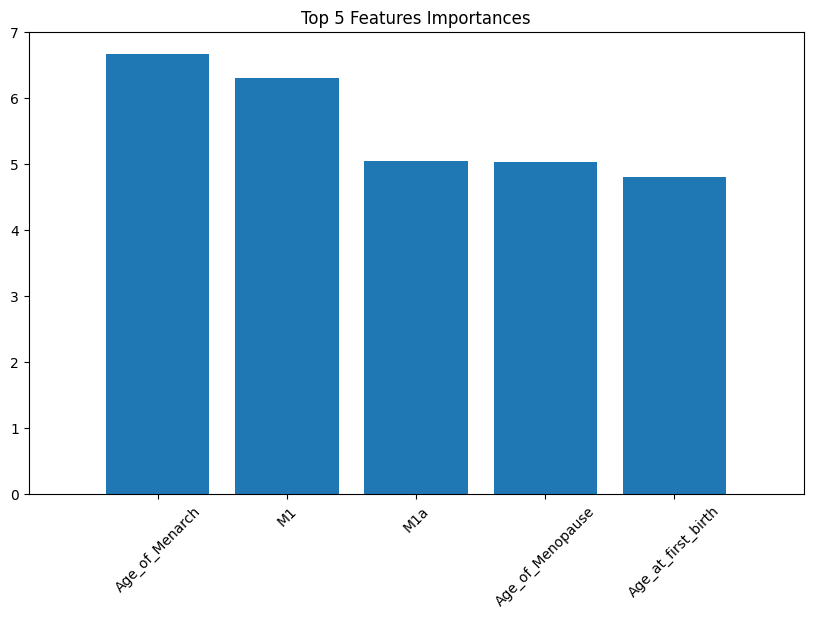

In [202]:
#CatBoost 모델의 feature importance 추출
if hasattr(best_model_cat, 'feature_importances_'):
    importances_cat = best_model_cat.feature_importances_

    #X_train에서 피처 이름 가져오기
    feature_names_smote = X_train.columns
    indices_smote = np.argsort(importances_cat)[::-1][:5]  #상위 5개 피처의 인덱스

    #상위 5개 피처와 중요도 추출
    top_features = indices_smote

    #데이터프레임 생성
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names_smote[top_features],
        'Importance': importances_cat[top_features]
    })

    #상위 5개 피처 표 출력
    print("Top 5 features importances:")
    print(feature_importance_df)

    #전체 변수 중요도 시각화 (상위 5개만)
    plt.figure(figsize=(10, 6))
    plt.title('Top 5 Features Importances')
    plt.bar(range(len(importances_cat[:5])), importances_cat[indices_smote], align='center')  #상위 5개만
    plt.xticks(range(len(importances_cat[:5])), feature_names_smote[indices_smote], rotation=45)  #상위 5개만
    plt.xlim([-1, len(importances_cat[:5])])  #x축 범위 조정
    plt.show()
else:
    print("CatBoost 모델에서 feature importances를 추출할 수 없습니다.")

- 주요 변수 추출 후 성능 평가: 성능 증/감에 따라 피처 선택 잘됐는지 확인 가능

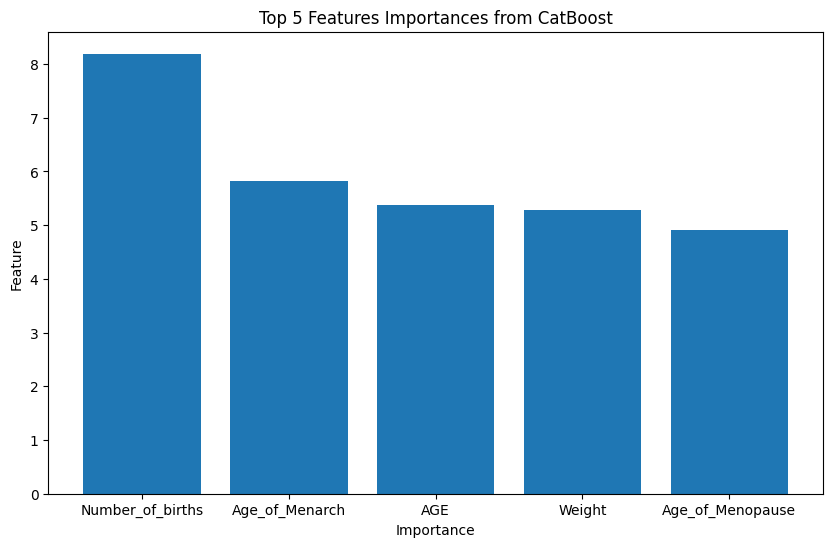

주요 변수 추출 후 CatBoost 성능 평가:
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       518
           1       0.76      0.67      0.71       522

    accuracy                           0.73      1040
   macro avg       0.73      0.73      0.73      1040
weighted avg       0.73      0.73      0.73      1040



In [207]:
import matplotlib.pyplot as plt
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# CatBoost 모델 생성
cat_model = CatBoostClassifier(silent=True, random_state=1111)  # 경고 메시지 출력 방지 및 랜덤 시드 고정

# 하이퍼파라미터 그리드
param_grid_cat = {
    'iterations': [100, 200],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
}

# GridSearchCV로 최적의 하이퍼파라미터 찾기
grid_search_cat = GridSearchCV(estimator=cat_model, param_grid=param_grid_cat, 
                                scoring='accuracy', cv=5, n_jobs=-1)
grid_search_cat.fit(X_train, y_train)  # 훈련 데이터로 학습

best_model_cat = grid_search_cat.best_estimator_  # 최적의 모델 가져오기

# 피처 중요도 추출
feature_importances = best_model_cat.get_feature_importance()  # 중요도 값
feature_names = X_train.columns  # 특성 이름
important_features = feature_names[feature_importances > 0.01]  # 중요도 값이 0.01보다 큰 피처 선택

# 상위 5개 피처 추출
top_features_indices = feature_importances.argsort()[-5:][::-1]
top_features = feature_names[top_features_indices]
top_importances = feature_importances[top_features_indices]

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.title('Top 5 Features Importances from CatBoost')
plt.bar(top_features, top_importances, align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 선택된 피처로 훈련 데이터 변환
X_train_selected_cat = X_train[important_features]
X_val_selected_cat = X_val[important_features]  # 검증 데이터 적용

# 최적 모델로 재훈련
best_model_cat.fit(X_train_selected_cat, y_train)

# 예측
y_pred_cat = best_model_cat.predict(X_val_selected_cat)

# 성능 평가
print("주요 변수 추출 후 CatBoost 성능 평가:")
print(classification_report(y_val, y_pred_cat))  # 성능 평가 결과 출력


##### 앙상블

In [203]:
# 모델 딕셔너리
models_df = {'XGBoost': xgb_model, 'RandomForest': rf_model, 'DecisionTree': df_model,
             'CatBoost': cat_model, 'LogisticRegression': log_model}

In [204]:
from sklearn.ensemble import VotingClassifier

#모델 설정
selected_models = [model for model in models_df.values()]

#먼저 각 모델을 학습시킴
for name, model in models_df.items():
    model.fit(X_train, y_train)  #각 모델을 훈련시킴

#Average Voting (항상 Soft Voting 사용)
voting = VotingClassifier(estimators=[(name, model) for name, model in models_df.items()], voting='soft')
print("Average Voting을 사용합니다.")

#앙상블 모델 학습
voting.fit(X_train, y_train)

#각 모델의 예측 결과 출력
print("\n각 모델의 예측 결과:")
for name, model in models_df.items():
    y_pred_model = model.predict(X_val)
    print(f'{name} 모델 예측:')
    print(classification_report(y_val, y_pred_model))

# 앙상블 모델의 예측 결과
y_pred_voting = voting.predict(X_val)
print("\n앙상블 모델 성능 평가:")
print(classification_report(y_val, y_pred_voting))

/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Average Voting을 사용합니다.


/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



각 모델의 예측 결과:
XGBoost 모델 예측:
              precision    recall  f1-score   support

           0       0.69      0.81      0.74       518
           1       0.77      0.63      0.69       522

    accuracy                           0.72      1040
   macro avg       0.73      0.72      0.72      1040
weighted avg       0.73      0.72      0.72      1040

RandomForest 모델 예측:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       518
           1       0.81      0.64      0.72       522

    accuracy                           0.74      1040
   macro avg       0.76      0.74      0.74      1040
weighted avg       0.76      0.74      0.74      1040

DecisionTree 모델 예측:
              precision    recall  f1-score   support

           0       0.62      0.59      0.61       518
           1       0.61      0.64      0.62       522

    accuracy                           0.62      1040
   macro avg       0.62      0.62      0.62      1040
weigh

In [217]:
from sklearn.ensemble import StackingClassifier

#스태킹 앙상블 
base_learners = [
    ('xgb', models_df['LogisticRegression']),
    ('rf', models_df['XGBoost']),
    ('log', models_df['CatBoost'])
]
meta_learner = models_df['RandomForest']
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

#스태킹 모델 학습
stacking_model.fit(X_train, y_train)

#예측 및 성능 평가
y_pred_stacking = stacking_model.predict(X_val)
print(classification_report(y_val, y_pred_stacking))

/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

              precision    recall  f1-score   support

           0       0.65      0.81      0.72       771
           1       0.76      0.57      0.65       799

    accuracy                           0.69      1570
   macro avg       0.70      0.69      0.69      1570
weighted avg       0.70      0.69      0.68      1570



- 40-50대 제외 연령대

In [208]:
from imblearn.over_sampling import SMOTE


filtered_other = filtered_df[filtered_df['Age_Group'] == '기타연령']

X = filtered_other.drop(columns=['Death', 'Survival_period', 'Age_Group'])
y = filtered_other['Death']

#오버샘플링
smote = SMOTE(random_state=1111)
X_resampled_age, y_resampled_age = smote.fit_resample(X, y)

#데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_resampled_age, y_resampled_age, 
                                                            random_state=1111, test_size=0.2)  

In [209]:
#DecisionTree
df_model = DecisionTreeClassifier(random_state=1111, class_weight='balanced')

param_grid_df = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search_df = GridSearchCV(estimator=df_model, param_grid=param_grid_df, 
                               scoring='accuracy', cv=5, n_jobs=-1)
grid_search_df.fit(X_train, y_train)

best_model_df = grid_search_df.best_estimator_  #최적의 모델 가져오기

importances_df = best_model_df.feature_importances_  #피처 중요도 추출

threshold = 0.01  #임계값 설정 (이 값보다 높은 중요도를 가진 피처 선택)
selector_df = SelectFromModel(best_model_df, threshold=threshold, prefit=True)

#선택된 피처로 훈련데이터 재학습
X_train_selected_df = selector_df.transform(X_train)
X_val_selected_df = selector_df.transform(X_val)  #검증 데이터 적용

best_model_df.fit(X_train_selected_df, y_train)  #최적의 모델로 재훈련

y_pred_df = best_model_df.predict(X_val_selected_df)  # 증 데이터 예측
print(classification_report(y_val, y_pred_df))  #성능 평가

              precision    recall  f1-score   support

           0       0.57      0.56      0.57       771
           1       0.59      0.60      0.59       799

    accuracy                           0.58      1570
   macro avg       0.58      0.58      0.58      1570
weighted avg       0.58      0.58      0.58      1570



/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [210]:
#RandomForest
rf_model = RandomForestClassifier(random_state=1111, class_weight='balanced')

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, 
                               scoring='accuracy', cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)  #훈련 데이터로 학습

best_model_rf = grid_search_rf.best_estimator_  #최적의 모델 가져오기

importances_rf = best_model_rf.feature_importances_  #피처 중요도 추출

threshold = 0.01  #임계값 설정(이 값보다 높은 중요도를 가진 피처 선택)
selector_rf = SelectFromModel(best_model_rf, threshold=threshold, prefit=True)

#선택된 피처로 훈련데이터 재학습
X_train_selected_rf = selector_rf.transform(X_train)
#검증데이터에 대한 피처 적용
X_val_selected_rf = selector_rf.transform(X_val)

best_model_rf.fit(X_train_selected_rf, y_train)  #최적의 모델로 훈련

y_pred_rf = best_model_rf.predict(X_val_selected_rf)  #모델 예측
print(classification_report(y_val, y_pred_rf))  #성능 평가

/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.69      0.83      0.75       771
           1       0.79      0.63      0.70       799

    accuracy                           0.73      1570
   macro avg       0.74      0.73      0.73      1570
weighted avg       0.74      0.73      0.73      1570



In [211]:
# XGBoost 모델 생성 및 하이퍼파라미터 최적화
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = XGBClassifier(random_state=1111, eval_metric='logloss')

# GridSearchCV 사용
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb,
                               scoring='accuracy', cv=5, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

best_model_xgb = grid_search_xgb.best_estimator_  # 최적의 모델 가져오기

# 피처 중요도 추출
importances_xgb = best_model_xgb.feature_importances_

threshold = 0.01  # 임계값 설정 (이 값보다 높은 중요도를 가진 피처 선택)
selector_xgb = SelectFromModel(best_model_xgb, threshold=threshold, prefit=True)

# 선택된 피처로 훈련 데이터 변환
X_train_selected_xgb = selector_xgb.transform(X_train)
X_val_selected_xgb = selector_xgb.transform(X_val)  # 검증 데이터 변환

# 최적 모델로 재훈련
best_model_xgb.fit(X_train_selected_xgb, y_train)

# 예측
y_pred_xgb = best_model_xgb.predict(X_val_selected_xgb)

# 성능 평가
print(classification_report(y_val, y_pred_xgb))  # 성능 평가 결과 출력

/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.66      0.82      0.73       771
           1       0.77      0.59      0.67       799

    accuracy                           0.70      1570
   macro avg       0.71      0.70      0.70      1570
weighted avg       0.72      0.70      0.70      1570



In [212]:
#CatBoost 모델 생성
cat_model = CatBoostClassifier(silent=True, random_state=1111)  #경고 메시지 출력 방지 및 랜덤 시드 고정

#하이퍼파라미터 그리드
param_grid_cat = {
    'iterations': [100, 200],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
}

#GridSearchCV로 최적의 하이퍼파라미터 찾기
grid_search_cat = GridSearchCV(estimator=cat_model, param_grid=param_grid_cat, 
                                scoring='accuracy', cv=5, n_jobs=-1)
grid_search_cat.fit(X_train, y_train)  #훈련 데이터로 학습

best_model_cat = grid_search_cat.best_estimator_  # 최적의 모델 가져오기

#특성 중요도 추출
feature_importances = best_model_cat.get_feature_importance()  # 중요도 값
feature_names = X_train.columns  # 특성 이름
important_features = feature_names[feature_importances > 0.01]

# 선택된 피처로 훈련 데이터 변환
X_train_selected_cat = X_train[important_features]
X_val_selected_cat = X_val[important_features]

#최적 모델로 재훈련
best_model_cat.fit(X_train_selected_cat, y_train)

# 예측
y_pred_cat = best_model_cat.predict(X_val_selected_cat)

# 성능 평가
print(classification_report(y_val, y_pred_cat))  # 성능 평가 결과 출력

              precision    recall  f1-score   support

           0       0.67      0.85      0.75       771
           1       0.81      0.59      0.68       799

    accuracy                           0.72      1570
   macro avg       0.74      0.72      0.72      1570
weighted avg       0.74      0.72      0.72      1570



In [213]:
log_model = LogisticRegression(max_iter=100, class_weight='balanced')

param_grid_log = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga'],
}

#GridSearchCV로 최적의 하이퍼파라미터 찾기
grid_search_log = GridSearchCV(estimator=log_model, param_grid=param_grid_log, 
                                scoring='accuracy', cv=5, n_jobs=-1)
grid_search_log.fit(X_train, y_train)
best_model_log = grid_search_log.best_estimator_  #최적의 모델 가져오기

#회귀 계수 추출 (피처 중요도)
importances_log = np.abs(best_model_log.coef_[0])

threshold = 0.01  #임계값 설정
selected_features = np.where(importances_log > threshold)[0]  #중요도 기준으로 피처 선택

#선택된 피처로 훈련데이터 재학습
X_train_selected_log = X_train.iloc[:, selected_features]
X_val_selected_log = X_val.iloc[:, selected_features]  #검증 데이터 적용

best_model_log.fit(X_train_selected_log, y_train)  #최적의 모델로 재훈련

y_pred_log = best_model_log.predict(X_val_selected_log)  #검증 데이터 예측
print(classification_report(y_val, y_pred_log))  #성능 평가

/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kojihye/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

              precision    recall  f1-score   support

           0       0.65      0.89      0.75       771
           1       0.83      0.54      0.66       799

    accuracy                           0.71      1570
   macro avg       0.74      0.71      0.70      1570
weighted avg       0.74      0.71      0.70      1570



Top 5 features importances:
          Feature  Importance
0             M1a   12.084056
1             N3b    6.867089
2             M1b    3.621897
3  adenocarcinoma    3.566328
4            PR_2    3.237869


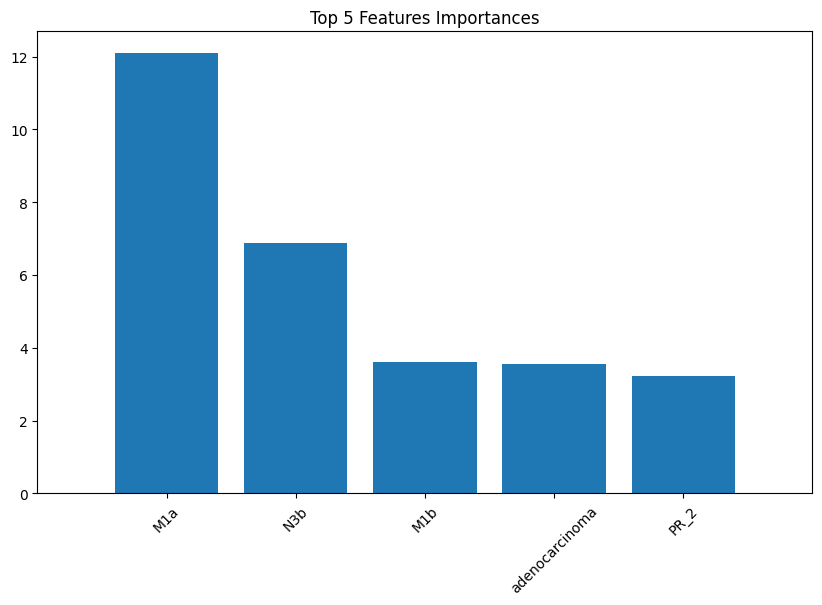

In [214]:
# CatBoost 모델의 feature importance 추출
if hasattr(best_model_cat, 'feature_importances_'):
    importances_age = best_model_cat.feature_importances_

    # X_train_rsmote에서 피처 이름 가져오기
    feature_names_smote = X_train.columns
    indices_smote = np.argsort(importances_age)[::-1][:5]  # 상위 5개 피처의 인덱스

    # 상위 5개 피처와 중요도 추출
    top_features = indices_smote

    # 데이터프레임 생성
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names_smote[top_features],
        'Importance': importances_age[top_features]
    })

    # 상위 5개 피처 표 출력
    print("Top 5 features importances:")
    print(feature_importance_df)

    # 전체 변수 중요도 시각화 (상위 5개만)
    plt.figure(figsize=(10, 6))
    plt.title('Top 5 Features Importances')
    plt.bar(range(len(importances_age[:5])), importances_age[indices_smote], align='center')  # 상위 5개만
    plt.xticks(range(len(importances_age[:5])), feature_names_smote[indices_smote], rotation=45)  # 상위 5개만
    plt.xlim([-1, len(importances_age[:5])])  # x축 범위 조정
    plt.show()
else:
    print("CatBoost 모델에서 feature importances를 추출할 수 없습니다.")